# Create scaling law plots
This Jupyter notebook creates plots of in silico experiments, where one parameter is varied, and another serves as a control held fixed at different values. The plots show validation loss as a function of the varied parameter, and the control parameter is used to color the plot. The plots are saved as images with a specific naming pattern.
The notebook is organized into the following sections:
1. Import the required libraries and modules.
2. Define the `plot_loss_vs_parameter` function, which is responsible for creating the plot. The function takes three arguments:
    - `config_dir`: The directory containing the config files.
    - `vary_param`: The independent variable or the parameter to vary.
    - `contrast_param`: The control variable, which is held constant at different levels.
3. The function reads the config files and calculates the minimum validation loss for each value of the varied parameter.
4. It then plots the minimum validation loss against the varied parameter for different levels of the control parameter. The points in the plot are colored according to the control parameter values.
5. Finally, the plot is saved as an image with the name
`scaling_plot_val_loss_vs_{param.parent}_{param.child}.png`.
At the end of the notebook, the `plot_loss_vs_parameter` function is called with specific arguments for `config_dir`, `vary_param`, and `contrast_param`.

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import find_config_files

In [27]:
def plot_loss_vs_parameter_v2(
    config_dir,
    vary_param,
    contrast_param,
    repeats_param,
    ax=None,
):
    """
    Plots the minimum validation loss against a varied parameter (vary_param)
    at different levels of another control parameter (contrast_param) using Seaborn.
    Args:
        config_dir: the directory containing the config files.
        vary_param: the independent variable.
        contrast_param: the control variable.
        repeats_param: the parameter to use for repetitions.
    """
    # Find the config files and their corresponding loss values
    configs = {}  # dict maps config file path to (loss, config)
    for file_path in find_config_files(config_dir):
        with open(file_path, "r") as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(
                    os.path.join(parent_dir, "loss_curves.csv"), index_col=0
                )
                loss = loss_df["centered_test_losses"][
                    loss_df["centered_test_losses"].idxmin()
                ]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

    # Split the parameters into their components
    vary_param = vary_param.split(".")
    contrast_param = contrast_param.split(".")
    repeats_param = repeats_param.split(".")

    # Create a data frame with the relevant data
    records = []
    for cfg_path, loss_cfg_tuple in configs.items():
        lvl = loss_cfg_tuple[1][contrast_param[0]][contrast_param[1]]
        val = loss_cfg_tuple[1][vary_param[0]][vary_param[1]]
        rep = loss_cfg_tuple[1][repeats_param[0]][repeats_param[1]]
        loss = loss_cfg_tuple[0]
        records.append((lvl, val, rep, loss))

    df = pd.DataFrame(
        records,
        columns=[
            ".".join(contrast_param),
            ".".join(vary_param),
            ".".join(repeats_param),
            "loss",
        ],
    )

    # Create the Seaborn plot
    ax_ = ax
    sns.set(style="white", font_scale=1.2)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x=".".join(vary_param),
        y="loss",
        hue=".".join(contrast_param),
        units=".".join(repeats_param),
        estimator=None,
        errorbar="se",
        marker="o",
        ax=ax,
    )

    # Customize plot labels and title
    ax.set_xlabel("%s %s" % (vary_param[0], vary_param[1]))
    ax.set_ylabel("Validation Loss")
    ax.set_title(
        "Scaling plot: loss vs {} {} \n Validation loss after training on different {}s".format(
            *vary_param, contrast_param[0]
        )
    )

    # Set the y-axis limits
    plt.ylim(0.0, 1.0)

    # Set x-axis scale to log if the varied parameter is train_size or hidden_size
    if vary_param[1] in {"worm_timesteps", "hidden_size"}:
        ax.set_xscale("log")

    # Save the plot as an image
    if ax_ is None:
        plt.savefig("figures/scaling_plot_val_loss_vs_{}_{}.png".format(*vary_param))

    # Return the data frame
    return df

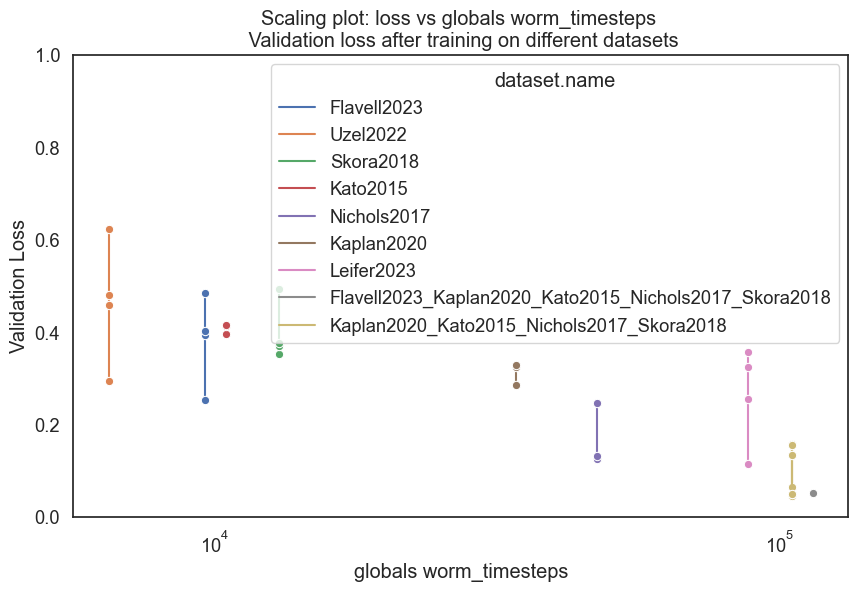

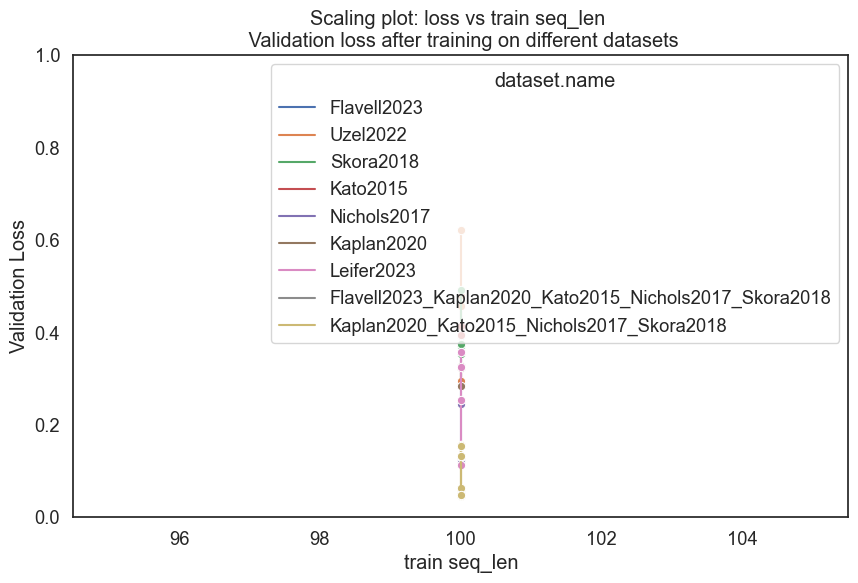

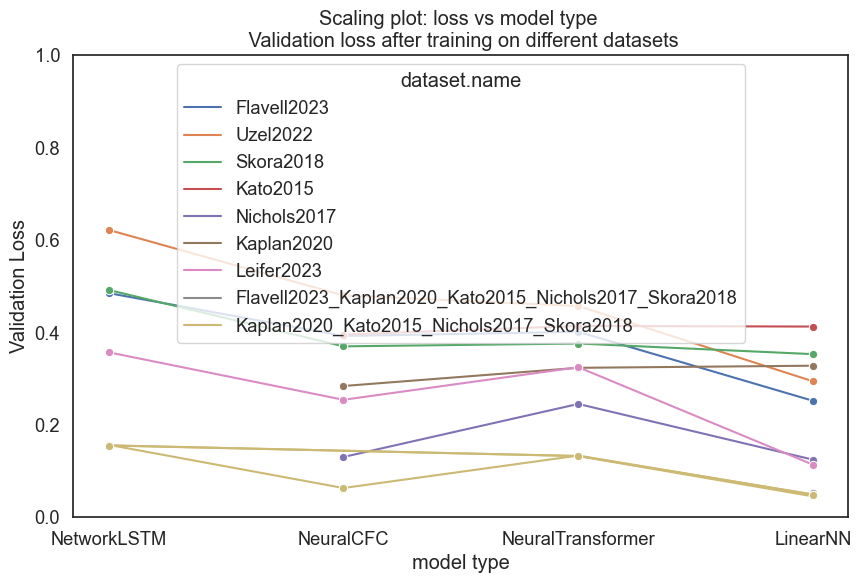

In [28]:
# Call the function for each hyperparameter
df = plot_loss_vs_parameter_v2(
    "../logs/hydra", "globals.worm_timesteps", "dataset.name", "globals.random_seed"
)

df = plot_loss_vs_parameter_v2(
    "../logs/hydra", "train.seq_len", "dataset.name", "globals.random_seed"
)

df = plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.type",
    "dataset.name",
    "globals.random_seed",
)

df = plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.num_layers",
    "dataset.name",
    "globals.random_seed",
)

df = plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.hidden_size",
    "dataset.name",
    "globals.random_seed",
)

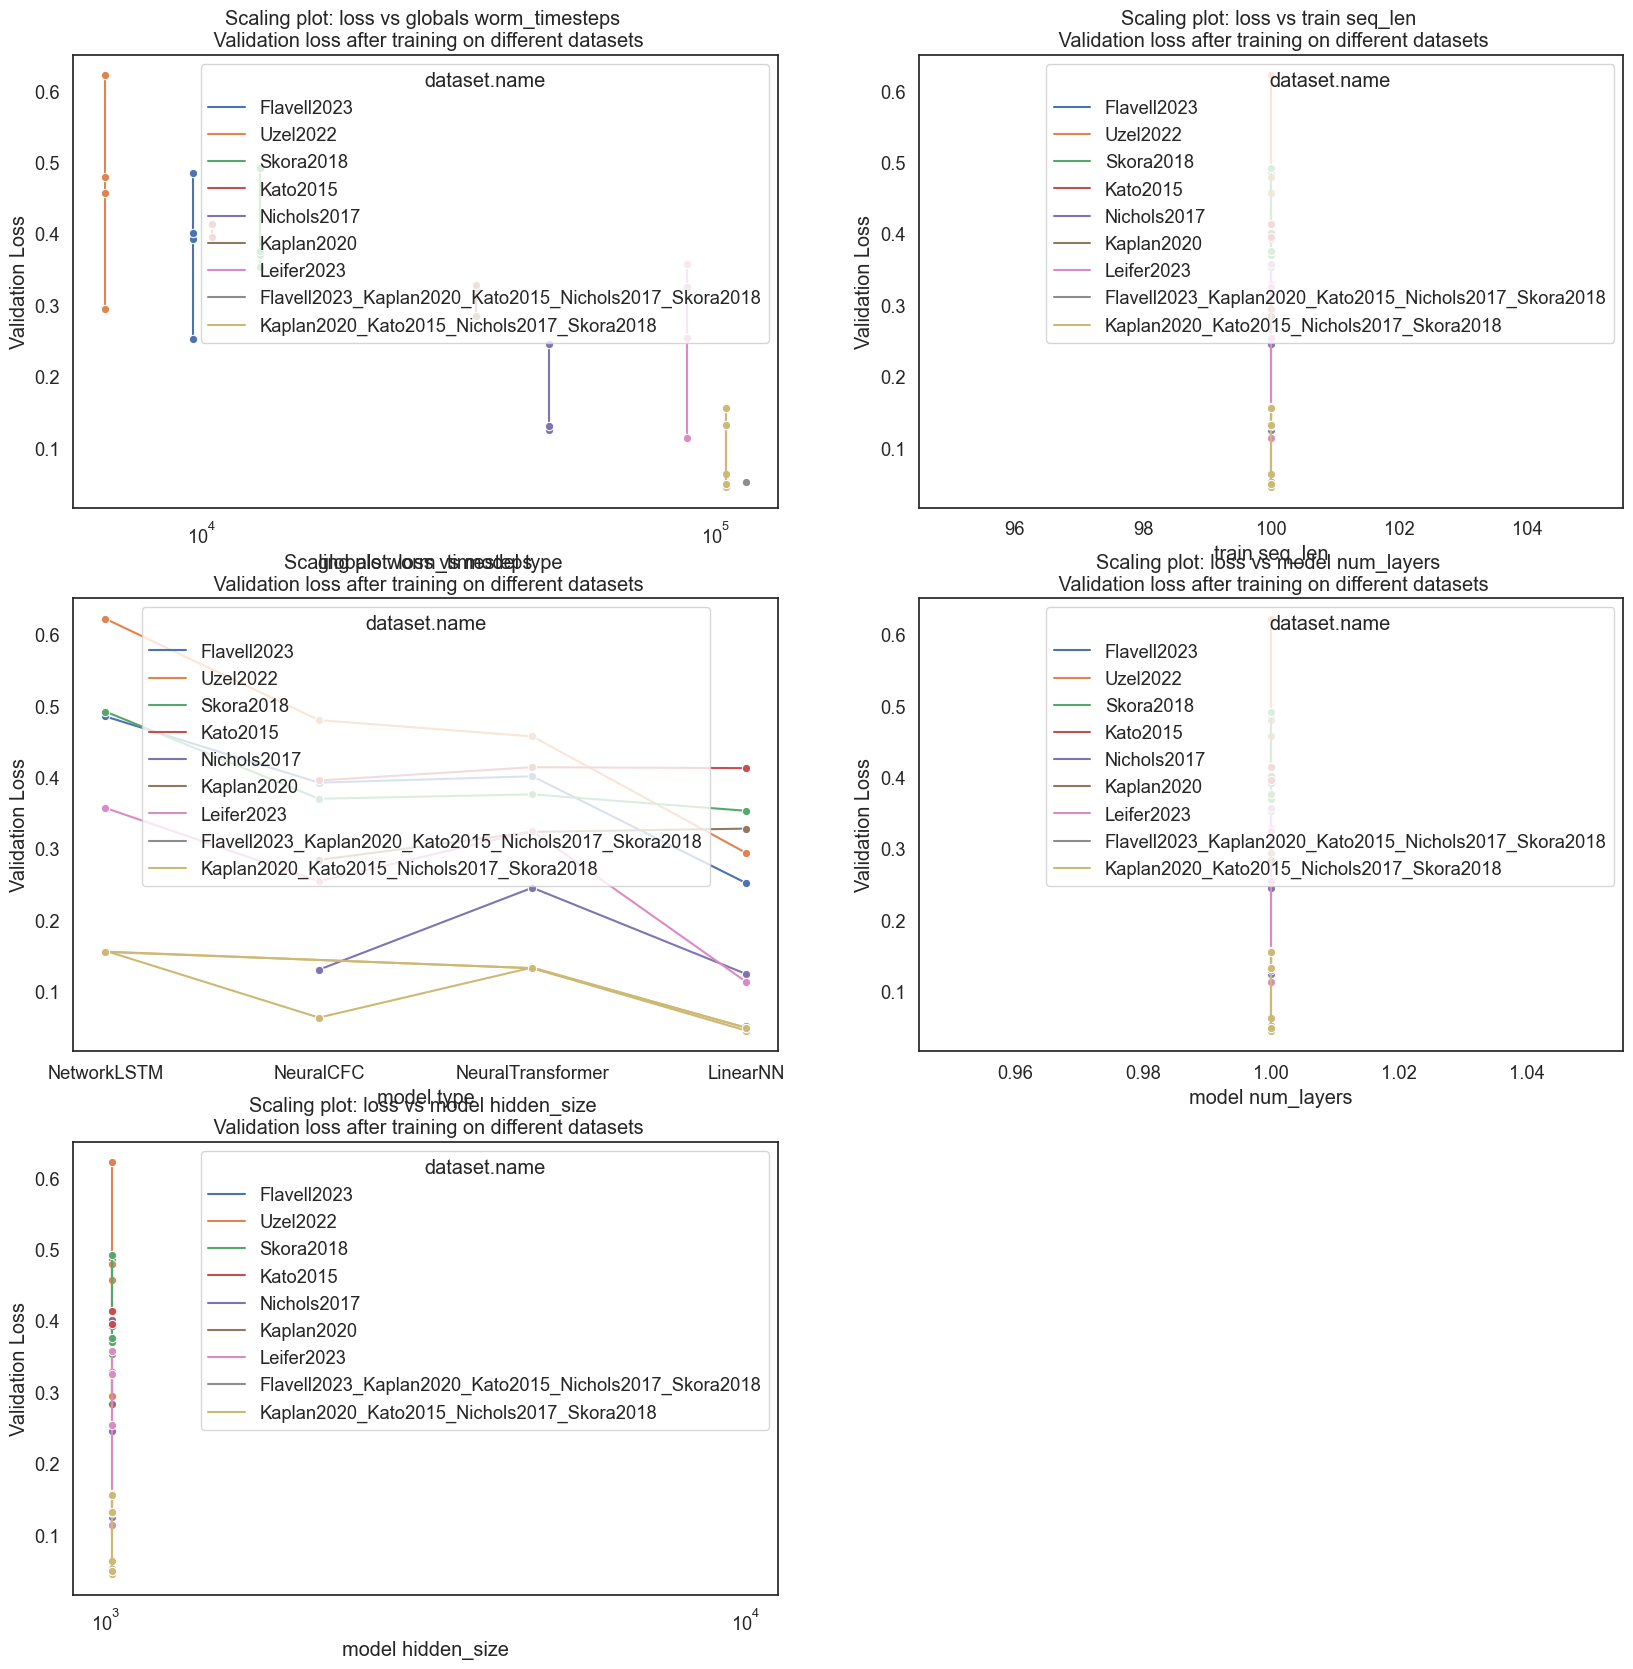

In [30]:
# Create a single figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Call the function for each hyperparameter, passing the appropriate subplot axis
plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "globals.worm_timesteps",
    "dataset.name",
    "globals.random_seed",
    axs[0, 0],
)
plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "train.seq_len",
    "dataset.name",
    "globals.random_seed",
    axs[0, 1],
)
plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.type",
    "dataset.name",
    "globals.random_seed",
    axs[1, 0],
)
plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.num_layers",
    "dataset.name",
    "globals.random_seed",
    axs[1, 1],
)
plot_loss_vs_parameter_v2(
    "../logs/hydra",
    "model.hidden_size",
    "dataset.name",
    "globals.random_seed",
    axs[2, 0],
)

# Remove the unused subplot
axs[2, 1].axis("off")

# Save the combined figure
fig.savefig("figures/combined_scaling_plots.png")